# rBergomi calibration with conditioning

### Cleaned version

$$
\newcommand{\cE}{\mathcal{E}}
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\bv}{\begin{verbatim}}
\newcommand{\ev}{\end{verbatim}}
\newcommand{\dsum}{\displaystyle\sum}
\newcommand{\sgn}{\mathrm{sign}}
\newcommand{\ee}[1]{\mathbb{E}\left[{#1}\right]}
\newcommand{\eef}[1]{\mathbb{E}\left[\left.{#1}\right|\cF_t\right]}
\newcommand{\eefm}[2]{\mathbb{E}^{#2}\left[\left.{#1}\right|\cF_t\right]}
$$

### Abstract

In this notebook, for a given set of parameters, we simulate the rough volatility model using the Hybrid BSS scheme with a view to calibrating to observed options prices.

In this version, we seek to completely change the logic of the code that should now proceed as follows:

- Compute Chebyshev knots
- Generate matrices of $W$ and $\tilde W$ for each of the (5) values of $H$
- Compute option values for all possible values of the parameters using conditioning
- Compute values of the objective function

In [4]:
setwd("/Users/bayerc/Documents/gatheral/chebyshev/rBergomiR/new")
load("spxOptionMetricsIVols.rdata")

The following code implements the efficient simulation scheme of  <span>[Bennedsen, Lunde and Pakkanen]<sup id="cite_ref-BLP" class="reference"><a href="#cite_note-BLP"><span>[</span>2<span>]</span></a></sup> .  Although this code assumes a flat variance swap curve, as we found earlier, normalized smiles are independent of the curve.

In [5]:
source("hybridScheme.R")
source("BlackScholes.R")
source("rBergomiObjectiveConditioned.R")

In [9]:
install.packages("chebpol")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [10]:
library(stinepack)
library(chebpol)
library(foreach)
library(doParallel)

*** chebpol: FFTW not used.
*** You should install it from http://fftw.org
*** or check if your OS-distribution provides it, and recompile.
Loading required package: iterators
Loading required package: parallel


- In the old code, for each $K$ and $t$, we compute the option price from a vector of $S_t$ of length $paths$.
- Now, for each $K$ and $t$, we compute the option price from two vectors of length $paths$: 
$$
w_t := \int_0^1 \,{\xi(t\,u)\,t}\,\cE\left(\eta\,t^H\, \tilde W_u   \right)\,du
$$
and
$$
y_t := \int_0^1\,\sqrt{\xi(t\,u)\,t}\,\sqrt{\cE\left(\eta\,t^H\, \tilde W_u   \right)}\,dW_u .
$$
Note that these depend only on $\eta$ and $H$ and not on $\rho$.


In [11]:
system.time(mcMatrix <- gen.WtildeH(H=0.05, paths=1e5, steps=200, distrib = 2000, max.cores = 8))

   user  system elapsed 
  1.132   0.498   8.686 

### Define the domain of the parameters

In [12]:
H.int <- c(0.02, 0.1)
etaTilde.int <- c(0.4, 0.8) # etaTilde = eta * sqrt(2*H)
rho.int <- c(-1.0, -0.8)
domain <- list(H.int, etaTilde.int, rho.int)

### Given $H$, $\eta$ and $t$, compute $w_t$ and $y_t$

In the following code, `xi` is a function of time

In [13]:
wy.list <- function(xi,H,etaTilde,pathMatrix){
    
    eta <- etaTilde/sqrt(2*H)
    
    steps <- dim(pathMatrix)[1]/2 # Number of time steps
    dt <- 1/steps
    sqrt.dt <- sqrt(dt)
    sqrt.2H <- sqrt(2 * H)
    x <- 1:steps
    ti <- x*dt
    ti.2H <- ti^(2 * H)
    
    function(expiry){ # k is vector of log-strikes
        xi.t <- xi(expiry*ti)
        eta.t <- eta * expiry^H
        tseq <- eta.t * eta.t/2 * ti.2H
        
        wy.path <- function(path){
            W <- path[1:steps]
            Wtilde <- path[(steps+1):(2*steps)]
            vtilde <- exp(eta.t * sqrt.2H * Wtilde - tseq)  # j is the path number
            v <- xi(expiry*ti)*vtilde
            v.t <- c(xi(0), v[-steps])*expiry
            w.t <- sum(v.t) * dt
            y.t <- sum(sqrt(v.t) * W) * sqrt.dt
            return(c(w.t,y.t)) # So for each path, we have the vectors w.t and y.t 
        }
    
        wy <- apply(pathMatrix,2,wy.path) # Now we have a matrix with paths as columns and BS values as rows
        return(wy)
        #return(list(w.t=wy[1,],y.t=wy[2,]))
        }
    }
    

### Final step: Compute option values given strike price and $w_t$, $y_t$

Given $H$ and $\eta$, for each $\rho$, we want to compute

$$
\ee{(S_T-K)^+} 
= K\,\ee{e^{\hat x_T}\, N\left( \frac{\hat x_T}{\sigma_T} + \frac{\sigma_T}{2}\right) -  N\left( \frac{\hat x_T}{\sigma_T} - \frac{\sigma_T}{2}\right)}
$$

with

$$
\sigma_T^2 = {\bar \rho}^2\,\int_0^1 \,{\xi(t\,u)\,t}\,\cE\left(\eta\,t^H\, \tilde W_u   \right)\,du = {\bar \rho}^2\,w_t
$$

and
$$
\beas
\hat x_T &=& -k + \rho\,\int_0^1\,\sqrt{\xi(t\,u)\,t}\,\sqrt{\cE\left(\eta\,t^H\, \tilde W_u   \right)}\,dW_u - \frac 12\,\rho^2\,\int_0^1 \,{\xi(t\,u)\,t}\,\cE\left(\eta\,t^H\, \tilde W_u   \right)\,du\\
&=& -k + \rho\,y_t - \frac 12\,\rho^2\,w_t.
\eeas
$$

We note in particular that conditioned option values depend only on $w_t$, $y_t$ and $k$.

In [14]:
c.wy <- function(wy.t,rho){
    
    function(k){ # k is vector of log-strikes
        sig <- sqrt((1 - rho^2) * wy.t[1,])
        x.shift <-  rho * wy.t[2,] - 1/2 * rho^2 * wy.t[1,]
        c <- exp(x.shift)*BSFormula(1, exp(k-x.shift), T=1,r=0, sig) # With luck, this is a vector of length #paths
        return(mean(c)) # Compute expectation of Black-Scholes across paths of volatility
        
        # Try returning implied volatility
        
        }
    }

### Function to generate a list of implied volatilities from the market by expiry

In [15]:
ivol.list <- function (ivolData) 
{
    
    gam <- 1/2
    bidVols <- as.numeric(ivolData$Bid)
    askVols <- as.numeric(ivolData$Ask)
    expDates <- unique(ivolData$Texp)
    nSlices <- length(expDates)
    slices <- 1:nSlices

    res <- vector("list", nSlices)

    atmVols <- numeric(nSlices)
    atmSkews <- numeric(nSlices)
    
    for (slice in slices) {
        t <- expDates[slice]
        texp <- ivolData$Texp
        bidVol <- bidVols[texp == t]
        askVol <- askVols[texp == t]
        midVol <- (bidVol + askVol)/2
        f <- (ivolData$Fwd[texp == t])[1]
        k <- log(ivolData$Strike[texp == t]/f)
        include <- !is.na(midVol)
        kIn <- k[include]
        volInterp <- function(xout) {
            stinterp(x = kIn, y = midVol[include], xout)$y
        }
        atmVol <- volInterp(0)
    
        bidVoln <- bidVol[include]/atmVol
        askVoln <- askVol[include]/atmVol
        midVoln <- midVol[include]/atmVol
        spreadn <- askVoln - bidVoln
        
        t.gamma <- t^gam
        
        z <- kIn/(atmVol * t.gamma)
        
        zmin <- min(z)
        zmax <- max(z)
        
        volInterpn <- function(xout) {
            stinterp(x = z, y = midVoln, xout)$y
        }
        
        atmSkewn <- (volInterpn(0.01) - volInterpn(-0.01))/0.02
        
        atmVols[slice] <- atmVol
        atmSkews[slice] <- atmSkewn
        
        res[[slice]] <- list(
            expiry=t,
            k=kIn,
            bidVol=bidVol[include],
            askVol=askVol[include],
            midVol=midVol[include],
            atmVol=atmVol,
            bidVoln=bidVoln,
            askVoln=askVoln,
            midVoln=midVoln,
            spreadn=spreadn
            )
        }
        
        return(res)
}

### Plot one smile

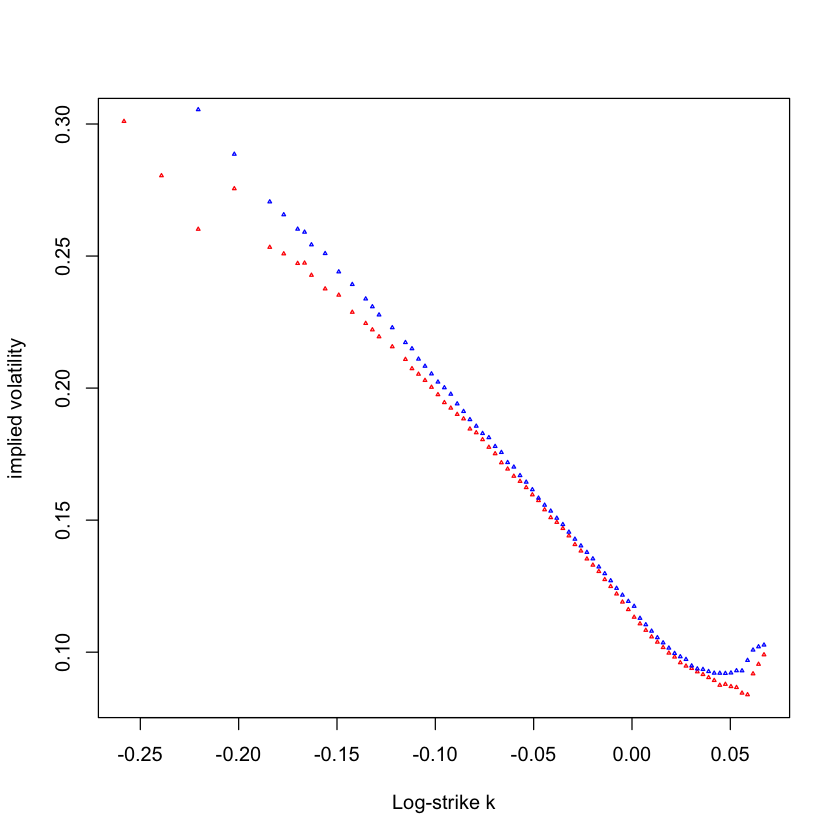

In [16]:
ivolData <- spxIvolList[["20130814"]]
ivols <- ivol.list(ivolData)
iv <- ivols[[5]]
plot(iv$k,iv$bidVol,pch=24,cex=.3,col="red",ylab="implied volatility",xlab="Log-strike k")
points(iv$k,iv$askVol,pch=24,cex=.3,col="blue")

### Finally, a function to compute a grid of values of the objective function

In [17]:
xi.func <- function(t){0.04+t*0}

In [18]:
objectiveMC.cheb.conditioned <- function(dim, domain, xi.func, ivolData, paths, steps){

#function(num, domain, xi=0.04, ivolData, paths, steps, distrib = 100, max.cores = 8){
    require(chebpol)
    require(foreach)
    require(doParallel)
    
    ## First generate the grid-points
    knots <- chebknots(dim, intervals=domain)
    H.vec <- knots[[1]]
    etatilde.vec <- knots[[2]]
    rho.vec <- knots[[3]]
    
    ## Define the output array
    val <- array(NA,dim=dim)
    
    ## Put input market implied vols into a more convenient format
    ivols <- ivol.list(ivolData)
    nSlices <- length(ivols)
    expiries <- sort(unique(ivolData$Texp))
    
#     if(is.null(xi.func)){xi.func <- function(t){0.04+t*0}}
    xi.func <- function(t){0.04+t*0}
 
    ######################################################################################################
    ## For each H, store a matrix of W and Wtilde
    cl.num <- detectCores() # Should be 8
    cl<-makeCluster(cl.num)
    registerDoParallel(cl)
    
    # Note that we need to export the function so it is available in each of the forked environments
    matrix.list <- foreach(i=1:length(H.vec),.export=c('hybridSchemeH')) %dopar% {
            hybridSchemeH(H=H.vec[i])(N=paths, steps=steps)
        }
    stopCluster(cl)
    ######################################################################################################
    
    # So far, about 25 seconds should have elapsed
       
    ######################################################################################################
    ## Function that given H and etatilde, computes values of the objective for each value of rho
    obj.by.etatildeH <- function(h.index,etatilde.index){
        
        H <- H.vec[h.index]
        etatilde <- etatilde.vec[etatilde.index]
        pathMatrix <- matrix.list[[h.index]]
        
        wy.expiries <- vapply(expiries,FUN=wy.list(xi=xi.func,H,etatilde,
                                       pathMatrix), FUN.VALUE=array(0,dim=c(2,paths)))
        # Given H and etatilde, we have w.t and y.t for each expiry
    
        sq.dist <- 0
        l.dist <- 0
                              
        # Now the loop over values of rho
                              
        for (rho.index in 1:length(H.vec)){
        
            rho <- rho.vec[rho.index]
        
            for (slice in 1:nSlices){
        
                wy.matrix <- wy.expiries[,,slice]
                iv <- ivols[[slice]]
                expiry <- iv$expiry
                atmVolMkt <- iv$atmVol
                atmVolModel <- BSImpliedVolCall(S0=1,K=1,T=expiry,r=0,c.wy(wy.matrix,rho=rho)(0))
                kModel <- iv$k * atmVolModel / atmVolMkt
        
                callPrices <- sapply(kModel,c.wy(wy.expiries[,,slice],rho=rho))
                volsModel <- BSImpliedVolCall(S0=1,K=exp(kModel),T=expiries[slice],r=0,callPrices)
                volsModeln <- volsModel/atmVolModel
            
                # Normalized volatilities
                # Note that wy.expiries[,,slice] has w.t in the first row and y.t in the second
        
                admit <- (volsModeln > 0.1)&(volsModeln < 10) # Check that normalized volatility is reasonable
        
                dist <- (volsModeln - iv$midVoln)/iv$spreadn * admit # Should be vector same length as kIn
                sq.dist <- sq.dist + sum(dist^2)
                l.dist <- l.dist + sum(admit) # Adjust for non-admissible points that contribute 0 to dist
            }
            val[h.index, etatilde.index, rho.index] <<- sq.dist/l.dist
        }
        
    }
    ######################################################################################################
#     ## Conventional loop
#     for (h.index in 4:length(H.vec)){
#         for (etatilde.index in 4:length(etatilde.vec)){
#             obj.by.etatildeH(h.index, etatilde.index)
#             }
#     }    
    ######################################################################################################
    ## Loop using doparallel and foreach
    cl.num <- detectCores() # Should be 8
    cl<-makeCluster(cl.num)
    registerDoParallel(cl)
    
    foreach(h.index=1:length(H.vec)) %:%
        foreach(etatilde.index=1:length(etatilde.vec)) %do% {obj.by.etatildeH(h.index, etatilde.index)}
    
    stopCluster(cl)
    ###################################################################################################### 
    
    return(val)
}

In [19]:
system.time(objFinal <- objectiveMC.cheb.conditioned(dim=c(5,5,5), domain, xi=NULL, ivolData, paths=1e3,steps=200))

   user  system elapsed 
 79.505   6.352  90.286 

In [20]:
objFinal

, , 1

          [,1]      [,2]      [,3]      [,4]     [,5]
[1,]  6.828703  5.797352  4.922001  5.474175  6.77919
[2,]  3.920556  4.704317  8.041266 11.034927 14.40795
[3,]  8.362390  8.190705  9.326393 11.996121 14.35485
[4,]  6.816556  5.135388  6.112325  7.835201 10.24751
[5,] 32.620451 22.294066 10.178116 10.333432 16.06986

, , 2

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,]  7.276987  6.122357  5.032677  5.371724  6.559048
[2,]  3.554956  4.516913  7.508961 10.794981 13.734025
[3,]  8.664606  8.507232  9.672258 12.375047 14.761113
[4,]  6.624690  4.931337  5.456667  7.648442  9.898810
[5,] 32.819200 22.404243 10.104496  9.998485 15.741594

, , 3

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,]  8.065715  6.725302  5.308772  5.314423  6.313281
[2,]  3.407325  4.247694  6.901195 10.139544 13.064918
[3,]  9.151063  9.019196 10.228878 12.974863 15.398411
[4,]  6.459259  4.589976  4.699304  6.920480  9.123246
[5,] 33.119161 22.590030 10.038542  9.561974 15.146631

, , 4

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,]  9.152074  7.604946  5.809163  5.396346  6.149183
[2,]  3.412360  4.239369  6.547584  9.635293 12.316993
[3,]  9.736419  9.641017 10.906097 13.694841 16.162732
[4,]  6.331871  4.277171  4.061621  6.214396  8.499093
[5,] 33.467422 22.829524 10.024347  9.154546 14.389962

, , 5

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 10.508850  8.818297  6.666124  5.733023  6.171505
[2,]  3.754827  4.487963  6.560887  9.486046 11.955113
[3,] 10.274803 10.223202 11.561280 14.404574 16.937118
[4,]  6.256593  4.106501  3.695448  5.964240  8.100423
[5,] 33.833937 23.070346 10.052900  8.858030 13.792486

About 8 minutes to compute the whole matrix with 10,000 paths

# Chebyshev interpolation and minimization of the objective function

Now we have the grid of values of the objective function at the Chebyshev knots, we can proceed to compute the optimal parameter set.

### Function to convert grid of objective function values to Chebyshev polynomial interpolation

In [21]:
objectiveMC.interpolation <- function(domain, obj_vals){
  require(chebpol)
  ## First generate the grid-points
  knots <- chebknots(dim(obj_vals), intervals=domain)
  cheb <- chebappx(val=obj_vals, intervals=domain)
  return(list(knots=knots, cheb=cheb))
}

In [22]:
obj.cheb.JG <- objectiveMC.interpolation(domain, obj_vals=objFinal)$cheb

### Now find the optimal parameters from the interpolating Chebyshev polynomial

##### Input:
- obj.cheb .. Chebyshev interpolation of objective function
- domain ... domain of interpolation
- guess.method ... "sobol" for choosing initial guesses according to Sobol points, "chebyshev" for using the Chebyshev knots.
- K ... number of Sobol points used as intial guesses. Otherwise the number of polynomials in each coordinate (a vector).
- method ... method for optim

##### Output: 
The full output of optim at the minimizing initail guess, together with the minimizing initial guess and the var of the minimal values for all the initial guesses.

##### Remark: 

obj.cheb is a polynomial, so we should be able to take the derivatives explicitly to use in the optimization. This does not seem possible in chebpol. A dedicated multivariate polynomial optimizer does not seem to exist in R.

First an auxiliary function to construct the initial guesses:

In [23]:
optim.objective.param0 <- function(guess.method, domain, K){
  if(guess.method == "sobol"){ ## use Sobol points
    stopifnot(length(K)==1) # stop if K is not a number
    param0 <- sobol(K, dim=3) ## these are in [0,1]
    to.domain <- function(x, domain){
      y <- rep(NA, length(domain))
      for(i in 1:length(domain))
        y[i] <- domain[[i]][1] + x[i]*(domain[[i]][2] - domain[[i]][1])
      return(y)
    }
    param0 <- t(apply(param0, 1, function(x) to.domain(x, domain)))
  }
  else{ ## use Chebyshev grid points
    stopifnot(length(K) == 3)
    knots <- chebknots(K, intervals=domain)
    param0 <- expand.grid(knots)
  }
  colnames(param0) <- c("H", "etaTilde", "rho")
  return(param0)
}

### Now the function that finds the optimum parameters given the polynomial interpolation `obj.cheb`

In [29]:
optim.objective <- function(obj.cheb, domain, K, 
                            guess.method="sobol", method="L-BFGS-B"){
  require(randtoolbox)
  require(chebpol)
  lower <- sapply(domain, function(x) x[1]) # lower bound in form assumed by optim
  upper <- sapply(domain, function(x) x[2])
  ## Choose initial guesses
  param0 <- optim.objective.param0(guess.method, domain, K)
  ## The optimization routine
  f <- function(param0) optim(param0, obj.cheb, method=method, 
                              lower=lower, upper=upper)
  ## apply for each choice of intial parameter
  res <- apply(param0, 1, f)
  ## extract the values, find the arg.min and return the corresponding values
  res.value <- sapply(1:10, function(i) res[[i]]$value)
  arg.min.index <- which.min(res.value)
  ret <- list(par=res[[arg.min.index]]$par, 
              value=res[[arg.min.index]]$value,
              counts=res[[arg.min.index]]$counts,
              convergence=res[[arg.min.index]]$convergence,
              message=res[[arg.min.index]]$message,
              param0=param0[arg.min.index,],
              var.values=var(res.value))
  return(ret)
}

In [33]:
optim.objective(obj.cheb.JG, domain, K=100, guess.method="sobol")

Loading required package: randtoolbox
Loading required package: rngWELL
This is randtoolbox. For overview, type 'help("randtoolbox")'.


$par
          H    etaTilde         rho 
 0.08823362  0.79373253 -0.92664999 

$value
[1] 2.564797

$counts
function gradient 
      34       34 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$param0
       H etaTilde      rho 
    0.08     0.50    -0.85 

$var.values
[1] 0.3025235

In [34]:
optim.objective(obj.cheb.JG, domain, K=c(5,5,5), guess.method="chebyshev")

,H,etaTilde,rho
7,0.08351141,0.7175571,-0.8048943


In [32]:
install.packages("randtoolbox")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
